# Introduction
In this notebook we will be teaching you how to load the data for Image Classification, as well as teaching you how to run initial baseline models across the dataset. We will be utilizing the Pytorch Lightning package to conduct all of our experiments. Documentation for this can be found at: https://lightning.ai/docs/pytorch/stable/

# Required Packages 
Below, we list all the required packages for this project. If you're new to notebooks, you can execute the current cell by pressing "Shift-Enter". Notably, we will use:

* **Pil:** For transforming images.
* **Matplotlib:** For displaying data.
* **PyTorch and PyTorch Lightning:** For creating and managing models, and loading data.

In [1]:
import os
import cv2
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.fcos import FCOSClassificationHead, FCOSRegressionHead
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights, SSD300_VGG16_Weights, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.ops import box_iou

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

## Defining Labels & Loading the Data
In this section, we define a custom class called CSUObjectDetectionDataset, which is responsible for loading our image data for a computer vision task. This class utilizes JSON files to access metadata, including the annotations that associate each image with object labels, which in this context are bounding box and object class index for each object.

Here's a breakdown of the CSUObjectDetectionDataset class:

Method Definitions:
* **__len__:** Returns the total number of images in the dataset.
* **__getitem__:** Retrieves an image by index, applies any transformations, and returns the image along with its object labels.

In [2]:
class CSUObjectDetectionDataset(Dataset):
    def __init__(self, json_file, transform=None, img_size=256):
        self.transform = transform
        self.img_size = img_size

        with open(os.path.join(json_file), 'r') as f:
            self.data = json.load(f)
            self.data_keys = list(self.data.keys())

    def __len__(self):
        return len(self.data_keys)

    def __getitem__(self, idx):
        tag = self.data_keys[idx]
        record = self.data[tag]
        img_path = record['image_path']
        image = Image.open(img_path).convert('RGB')
        
        boxes = torch.tensor(record['boxes'], dtype=torch.float32)
        divider = 512 / self.img_size
        boxes = boxes / divider
        labels = torch.tensor(record['labels'], dtype=torch.int64)
        # NOTE: class index 0 is for background
        labels += 1

        target = {
            'boxes': boxes,
            'labels': labels,
        }

        if self.transform:
            image = self.transform(image)

        return image, target

## Defining Our Models
Now that we have created a class that will load our data, we will create our class that contains our machine learning model! We begin by defining a class and constructor called "ObjectDetectionModel", before creating a definition called "_get_model". In "_get_model", we have pre-defined 5 seperate models from PyTorch, such as: Faster R-CNN, and RetinaNet. More documentation on these models can be found here: https://pytorch.org/vision/stable/models.html.

After we define our models, we create a "forward" definition, which will allow the training to progress, and three stepping functions: train, val, and test. Finally, we define an optimizer, which can be useful in training, and reducing things such as overfitting.

If you are not familiar object detection loss functions, please check this link: https://www.v7labs.com/blog/mean-average-precision

In [3]:
class ObjectDetectionModel(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=0.001, model_name='fasterrcnn_resnet50_fpn'):
        super(ObjectDetectionModel, self).__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.model_name = model_name
        self.model = self._get_model()

    def _get_model(self):
        if self.model_name == 'fasterrcnn_resnet50_fpn': # DONE
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
            return model
        elif self.model_name == 'retinanet_resnet50_fpn':
            model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
                weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
            )
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = RetinaNetClassificationHead(
                in_channels=256,
                num_anchors=num_anchors,
                num_classes=self.num_classes
            )
            return model
        elif self.model_name == 'ssd300_vgg16':
            size = 512
            model = torchvision.models.detection.ssd300_vgg16(
                weights=SSD300_VGG16_Weights.COCO_V1
            )
            in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = SSDClassificationHead(
                in_channels=in_channels,
                num_anchors=num_anchors,
                num_classes=self.num_classes,
            )
            model.transform.min_size = (size,)
            model.transform.max_size = size
            return model
        elif self.model_name == 'ssdlite320_mobilenet_v3_large':
            size = 512
            model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
                weights='DEFAULT'
            )
            in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = SSDClassificationHead(
                in_channels=in_channels,
                num_anchors=num_anchors,
                num_classes=self.num_classes,
            )
            model.transform.min_size = (size,)
            model.transform.max_size = size
            return model
        elif self.model_name == 'fcos_resnet50_fpn':
            model = torchvision.models.detection.fcos_resnet50_fpn(
                weights='DEFAULT'
            )
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = FCOSClassificationHead(
                in_channels=256,
                num_anchors=num_anchors,
                num_classes=self.num_classes,
            )
            model.transform.min_size = (256, )
            model.transform.max_size = 256
            for param in model.parameters():
                param.requires_grad = True
            return model
        else:
            raise ValueError(f"Model {self.model_name} not supported")

    def forward(self, x):
        if self.model_name == 'fasterrcnn_resnet50_fpn':
            return self.model(x)
        elif self.model_name == 'retinanet_resnet50_fpn':
            features = self.model.backbone(x)
            if isinstance(features, dict):
                features = list(features.values())
            cls_logits = []
            bbox_regression = []
            for feature in features:
                cls_logits.append(self.model.head.classification_head(feature))
                bbox_regression.append(self.model.head.regression_head(feature))
            return {"cls_logits": cls_logits, "bbox_regression": bbox_regression}
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        self.log('train_loss', losses, sync_dist=True)
        return losses

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(images, targets)
        self.evaluate(outputs, targets, mode='val')
    
    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(images, targets)
        self.evaluate(outputs, targets, mode='test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def evaluate(self, outputs, targets, mode='val'):
        pred_boxes = [output['boxes'] for output in outputs]
        pred_scores = [output['scores'] for output in outputs]
        pred_labels = [output['labels'] for output in outputs]
        true_boxes = [target['boxes'] for target in targets]
        true_labels = [target['labels'] for target in targets]

        iou_thresholds = [0.5, 0.75]
        aps_per_threshold = {iou: [] for iou in iou_thresholds}
        ar_per_threshold = {iou: [] for iou in iou_thresholds}
        precision_per_class = {label: [] for label in range(1, 6)}
        recall_per_class = {label: [] for label in range(1, 6)}

        for i in range(len(pred_boxes)):
            pred_box = pred_boxes[i]
            pred_score = pred_scores[i]
            pred_label = pred_labels[i]
            true_box = true_boxes[i]
            true_label = true_labels[i]

            for label in torch.unique(true_label):
                pred_mask = pred_label == label
                true_mask = true_label == label

                pred_box_class = pred_box[pred_mask]
                pred_score_class = pred_score[pred_mask]
                true_box_class = true_box[true_mask]

                if len(pred_box_class) == 0 or len(true_box_class) == 0:
                    continue

                for iou_threshold in iou_thresholds:
                    ious = box_iou(pred_box_class, true_box_class)
                    true_positives = ious.max(1)[0] > iou_threshold

                    sorted_indices = torch.argsort(pred_score_class, descending=True)
                    true_positives = true_positives[sorted_indices]

                    cumulative_true_positives = torch.cumsum(true_positives, dim=0)
                    cumulative_false_positives = torch.cumsum(~true_positives, dim=0)

                    # NOTE: For avoiding division by zero, 1e-10 is added to calculate precision and recall
                    precision = cumulative_true_positives / (cumulative_true_positives + cumulative_false_positives + 1e-10)
                    recall = cumulative_true_positives / (len(true_box_class) + 1e-10)

                    device = precision.device
                    ap = self.calculate_ap(precision, recall, device)
                    if torch.isnan(ap) or torch.isinf(ap):
                        print(f'Invalid AP value for class {label.item()} at IoU {iou_threshold}')
                        continue

                    aps_per_threshold[iou_threshold].append(ap)

                    self.log(f'{mode}_precision_class_{label.item()}_iou_{iou_threshold}', precision[-1], sync_dist=True)
                    self.log(f'{mode}_recall_class_{label.item()}_iou_{iou_threshold}', recall[-1], sync_dist=True)
                    self.log(f'{mode}_ap_class_{label.item()}_iou_{iou_threshold}', ap, sync_dist=True)

                    ar_per_threshold[iou_threshold].append(recall[-1])
                    precision_per_class[label.item()].append(precision[-1].item())
                    recall_per_class[label.item()].append(recall[-1].item())

        for iou_threshold in iou_thresholds:
            if aps_per_threshold[iou_threshold]:
                mAP = torch.mean(torch.tensor(aps_per_threshold[iou_threshold]))
                self.log(f'{mode}_mAP_iou_{iou_threshold}', mAP, sync_dist=True)
            if ar_per_threshold[iou_threshold]:
                mAR = torch.mean(torch.tensor(ar_per_threshold[iou_threshold]))
                self.log(f'{mode}_mAR_iou_{iou_threshold}', mAR, sync_dist=True)

        # NOTE: Calculate overall AP across IoU thresholds
        all_aps = [ap for aps in aps_per_threshold.values() for ap in aps]
        if all_aps:
            overall_mAP = torch.mean(torch.tensor(all_aps))
            self.log(f'{mode}_mAP', overall_mAP, sync_dist=True)

        # NOTE: Calculate overall AR across IoU thresholds
        all_ars = [ar for ars in ar_per_threshold.values() for ar in ars]
        if all_ars:
            overall_mAR = torch.mean(torch.tensor(all_ars))
            self.log(f'{mode}_mAR', overall_mAR, sync_dist=True)

        # NOTE: Log Precision and Recall for each class
        for label in precision_per_class:
            if precision_per_class[label]:
                avg_precision = torch.mean(torch.tensor(precision_per_class[label]))
                self.log(f'{mode}_precision_class_{label}', avg_precision, sync_dist=True)
            if recall_per_class[label]:
                avg_recall = torch.mean(torch.tensor(recall_per_class[label]))
                self.log(f'{mode}_recall_class_{label}', avg_recall, sync_dist=True)

    def calculate_ap(self, precision, recall, device):
        new_recalles = torch.cat((torch.tensor([0.0], device=device), recall, torch.tensor([1.0], device=device)))
        new_precisions = torch.cat((torch.tensor([0.0], device=device), precision, torch.tensor([0.0], device=device)))

        for I in range(new_precisions.size(0) - 1, 0, -1):
            new_precisions[I - 1] = torch.max(new_precisions[I - 1], new_precisions[I])

        indices = torch.where(new_recalles[1:] != new_recalles[:-1])[0]
        ap = torch.sum((new_recalles[indices + 1] - new_recalles[indices]) * new_precisions[indices + 1])
        return ap

## We can now tie everything together, load the data, and define our model!

###  Transformations
* **Preprocessing Steps:** The script applies several transformations to prepare images for neural network processing. These include:
* **Resize:** Adjusts images to a uniform size (256 pixels).
* **ToTensor:** Converts images to PyTorch tensors.
* **Normalize:** Scales image pixel values using means and standard deviations of ImageNet, aligning with common model expectations.

### Dataset and DataLoaders
* **Dataset Loading:** Loads training, validation, and testing datasets from specified JSON files, which contain paths to images and their corresponding labels.
* **DataLoaders:** Configured to handle data in batches of 32, enhancing computational efficiency. Utilizes 16 worker threads for parallel data loading.
Training DataLoader shuffles data to ensure model generalization, while validation and test loaders process data sequentially.

### Model Configuration
* **Model Selection:** Offers a choice among several pre-defined models (e.g., Faster R-CNN, RetinaNet, and SSD). The default model is Faster R-CNN.
* **ObjectDetectionModel Class:** Custom class that extends pl.LightningModule, handling tasks such as forward passes, training steps, and validation/testing evaluations.

### Training Setup
* **ModelCheckpoint:** Saves the model with the highest validation metric, ensuring retention of the best-performing version.
* **EarlyStopping:** Prevents overfitting by halting training if validation metric does not improve for ten consecutive epochs.

### Trainer Configuration:
Set to train for up to 100 epochs with GPU acceleration, if available. Incorporates callbacks to monitor and optimize training process efficiency and effectiveness.

### Execution
The Trainer object orchestrates the training, validation, and testing phases, utilizing the configurations specified for the ObjectDetectionModel and the data provided through the DataLoaders.

In [4]:
model_name = 'fasterrcnn_resnet50_fpn'
img_size = 256
if 'ssd' in model_name:
    img_size = 512
batch_size = 8
n_workers = 16
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CSUObjectDetectionDataset(json_file='/data/CCVC/neurips_2024/detection/train_labels.json', transform=transform, img_size=img_size)
val_dataset = CSUObjectDetectionDataset(json_file='/data/CCVC/neurips_2024/detection/val_labels.json', transform=transform, img_size=img_size)
test_dataset = CSUObjectDetectionDataset(json_file='/data/CCVC/neurips_2024/detection/test_labels.json', transform=transform, img_size=img_size)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, drop_last=True, collate_fn=lambda x: tuple(zip(*x)))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, drop_last=True, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, drop_last=True, collate_fn=lambda x: tuple(zip(*x)))

num_classes = 6 # NOTE: 5 classes + 1 background (0: background, 1: lightpost, 2: door, 3: trashcan, 4: bickrack, 5: electrical box)
model = ObjectDetectionModel(num_classes=num_classes, learning_rate=0.00001, model_name=model_name)

checkpoint_callback = ModelCheckpoint(
    monitor='val_mAP',
    dirpath='./checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='max'
)
early_stopping_callback = EarlyStopping(
    monitor='val_mAP',
    patience=10,
    verbose=True,
    mode='max'
)
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboa

## Verify Dataloading
An important step when working in Computer Vision is double checking your data. Below, the method "showImages", will display 5 images that we have loaded randomly. You can run the cell multiple times, to see a variety of the dataset. Note these images will be what the model sees, so they may look different than the original data. We recommend looking at images from all the data splits, train, test, and val.

In [12]:
def get_color_map():
    color_map = {
        0: (0, 0, 255),
        1: (0, 255, 0),
        2: (255, 0, 0),
        3: (0, 255, 255),
        4: (255, 0, 255),
    } 
    return color_map
def get_class_names():
    class_names = [
        'lightpost',
        'door',
        'trashcan',
        'bikerack',
        'electricalbox'
    ]
    return class_names

def draw_boxes(image, boxes, labels):
    color_map = get_color_map()
    str_class_names = get_class_names()
    for box, label in zip(boxes, labels):
        box = box.astype(int)
        color = color_map[label-1]
        thickness = 2
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        image = cv2.rectangle(image, (int(box[0]/256 * 960), int(box[1]/256 * 540)), (int(box[2]/256 * 960), int(box[3]/256 * 540)), color, thickness)
        image = cv2.putText(image, str_class_names[label-1], (int(box[0]/256 * 960), int(box[1]/256 * 540) - 10), font, font_scale, color, font_thickness)
    return image

def show_images(dataset):
    fig = plt.figure(figsize=(20, 10))
    random_idx = np.random.choice(len(dataset), 1, replace=False)
    print(random_idx)
    # Retrieve a random image and its label
    image, target = dataset[random_idx[0]]
    # Reverse the normalization process
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean
    image = image.permute(1, 2, 0).numpy()
    # Resize the image to (960, 540) for better visualization
    image = cv2.resize(image, (960, 540))
    labels = target['labels'].numpy()
    boxes = target['boxes'].numpy()
    image = draw_boxes(image, boxes, labels)
    plt.axis('off')
    plt.imshow(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[966]


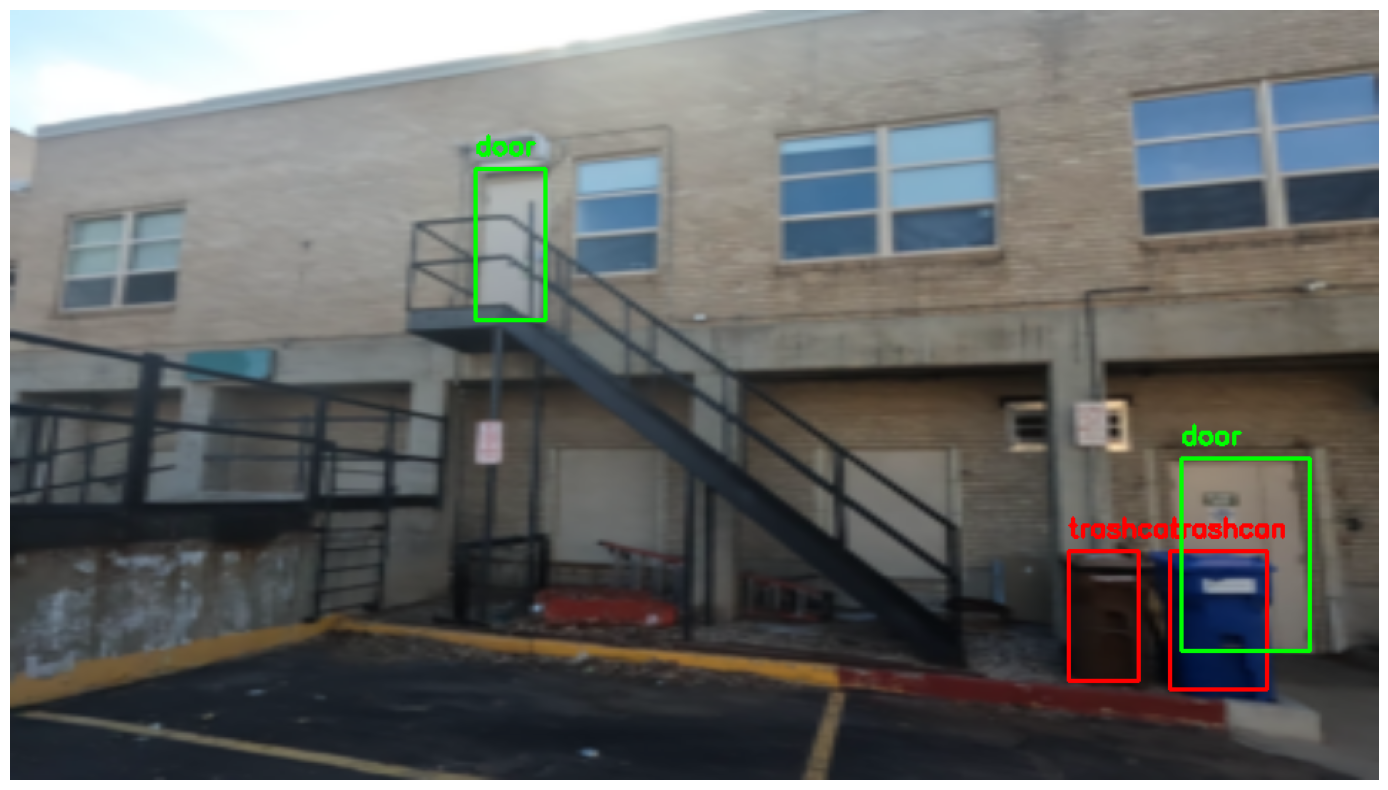

In [14]:
show_images(train_dataset)

## Utilizing the Pytorch Trainer Method
Understanding trainer.fit(model, train_loader, val_loader) in PyTorch Lightning

* **trainer.fit()** automates the training process for your machine learning model. Here’s what each component is for:

* **model:** This is your neural network, defined in a class that handles computations like forward passes and backpropagation.

* **train_loader:** A DataLoader that provides batches of training data. It shuffles the data to help the model generalize better.

* **val_loader:** Similar to train_loader but for validation data, used to evaluate the model’s performance on unseen data after each training epoch to monitor for overfitting.




In [15]:
trainer.fit(model, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/cjung/ccvc/neurips_2024/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.279   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.69it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 916/916 [05:51<00:00,  2.60it/s, v_num=167]      

Metric val_mAP improved. New best score: 0.318


Epoch 1: 100%|██████████| 916/916 [05:52<00:00,  2.60it/s, v_num=167]

Metric val_mAP improved by 0.073 >= min_delta = 0.0. New best score: 0.392


Epoch 3: 100%|██████████| 916/916 [05:51<00:00,  2.60it/s, v_num=167]

Metric val_mAP improved by 0.008 >= min_delta = 0.0. New best score: 0.399


Epoch 13: 100%|██████████| 916/916 [05:49<00:00,  2.62it/s, v_num=167]

Monitored metric val_mAP did not improve in the last 10 records. Best score: 0.399. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 916/916 [05:49<00:00,  2.62it/s, v_num=167]


## Testing our Model
Similar to how we trained our model with the PyTorch Lightning Trainer, we can utilize the trainer method to test our model.

In [16]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 80/80 [00:15<00:00,  5.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_ap_class_1_iou_0.5          0.36773502826690674
   test_ap_class_1_iou_0.75          0.1230769231915474
    test_ap_class_2_iou_0.5           0.700928807258606
   test_ap_class_2_iou_0.75          0.38359373807907104
    test_ap_class_3_iou_0.5           0.843124508857727
   test_ap_class_3_iou_0.75          0.2861635088920593
    test_ap_class_4_iou_0.5           0.658151388168335
   test_ap_class_4_iou_0.75          0.18414177000522614
    test_ap_class_5_iou_0.5          0.4578947424888611
   test_ap_class_5_iou_0.75          0.20000000298023224
           test_mAP                  0.41266730427742004
       test_mA

[{'test_precision_class_1_iou_0.5': 0.37290599942207336,
  'test_recall_class_1_iou_0.5': 0.3837606906890869,
  'test_ap_class_1_iou_0.5': 0.36773502826690674,
  'test_precision_class_1_iou_0.75': 0.11282051354646683,
  'test_recall_class_1_iou_0.75': 0.12820513546466827,
  'test_ap_class_1_iou_0.75': 0.1230769231915474,
  'test_precision_class_2_iou_0.5': 0.5727499127388,
  'test_recall_class_2_iou_0.5': 0.731249988079071,
  'test_ap_class_2_iou_0.5': 0.700928807258606,
  'test_precision_class_2_iou_0.75': 0.3388839066028595,
  'test_recall_class_2_iou_0.75': 0.3916666805744171,
  'test_ap_class_2_iou_0.75': 0.38359373807907104,
  'test_mAP_iou_0.5': 0.5804281830787659,
  'test_mAR_iou_0.5': 0.6098425984382629,
  'test_mAP_iou_0.75': 0.24490651488304138,
  'test_mAR_iou_0.75': 0.25473013520240784,
  'test_mAP': 0.41266730427742004,
  'test_mAR': 0.4322863519191742,
  'test_precision_class_1': 0.21601486206054688,
  'test_recall_class_1': 0.22319643199443817,
  'test_precision_class_2'

## Displaying Predictions!
After testing, similar to how we verified our data, we may display images that our model has classified. We often want to display mis-classifications, to see where our model is performing poorly, before making changes to address these issues.

In [17]:
# Show the model's prediction on a random image from the test dataset
def show_prediction(dataset):
    fig = plt.figure(figsize=(20, 10))
    random_idx = np.random.choice(len(dataset), 1, replace=False)
    print(random_idx)
    # Retrieve a random image and its label
    image, target = dataset[random_idx[0]]
    model_input = image.unsqueeze(0)
    model_input = model_input.to(model.device)
    model.eval()
    with torch.no_grad():
        output = model(model_input)
    # Retrieve the model's prediction
    pred_boxes = output[0]['boxes'].cpu().numpy()
    pred_labels = output[0]['labels'].cpu().numpy()
    # Reverse the normalization process
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean
    image = image.permute(1, 2, 0).numpy()
    # Resize the image to (960, 540) for better visualization
    image = cv2.resize(image, (960, 540))
    image = draw_boxes(image, pred_boxes, pred_labels)
    plt.axis('off')
    plt.imshow(image)

[330]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


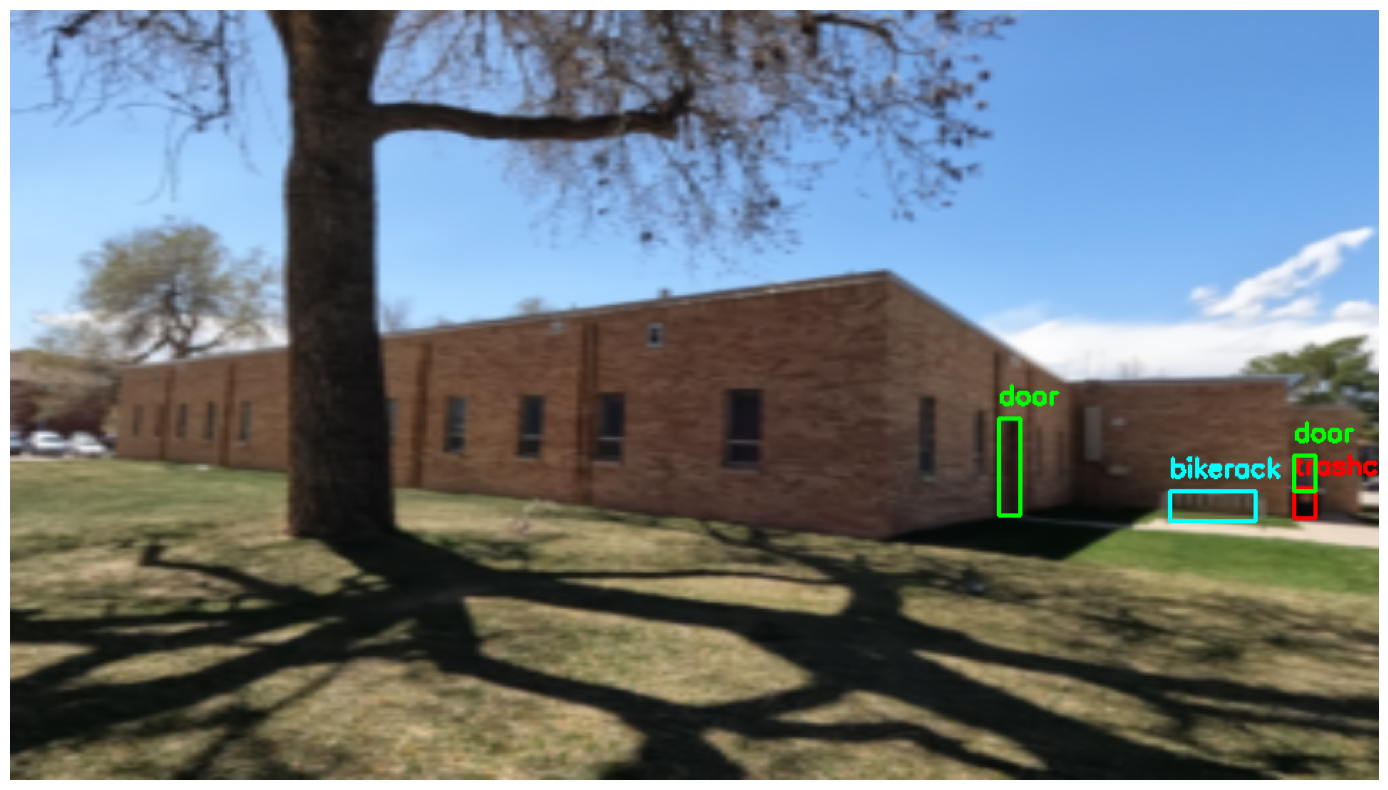

In [18]:
show_prediction(test_dataset)

## Saving Our Model
In case of failure, or model deployment we often want to save our best model. The line of code below will save the "weights" of the model, which we can reuse in the future.

In [ ]:
torch.save(model.state_dict(), f"/data/CCVC/neurips_2024/detection/weights/{model_name}.pth")

## Running All models

In [ ]:
model_names = ['retinanet_resnet50_fpn', 'fcos_resnet50_fpn', 'fasterrcnn_resnet50_fpn', 'ssd300_vgg16', 'ssdlite320_mobilenet_v3_large']

for model_name in model_names:

    img_size = 256
    if 'ssd' in model_name:
        img_size = 512
    batch_size = 8
    n_workers = 64
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CSUObjectDetectionDataset(json_file='/data/CCVC/neurips_2024/detection/train_labels.json', transform=transform, img_size=img_size)
    val_dataset = CSUObjectDetectionDataset(json_file='/data/CCVC/neurips_2024/detection/val_labels.json', transform=transform, img_size=img_size)
    test_dataset = CSUObjectDetectionDataset(json_file='/data/CCVC/neurips_2024/detection/test_labels.json', transform=transform, img_size=img_size)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, drop_last=True, collate_fn=lambda x: tuple(zip(*x)))
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, drop_last=True, collate_fn=lambda x: tuple(zip(*x)))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, drop_last=True, collate_fn=lambda x: tuple(zip(*x)))

    num_classes = 6 # 5 classes + 1 background (0: background, 1: lightpost, 2: door, 3: trashcan, 4: bickrack, 5: electrical box)
    model = ObjectDetectionModel(num_classes=num_classes, learning_rate=0.00001, model_name=model_name)

    checkpoint_callback = ModelCheckpoint(
        monitor='val_mAP',
        dirpath='./checkpoints',
        filename='best-checkpoint',
        save_top_k=1,
        mode='max'
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_mAP',
        patience=10,
        verbose=True,
        mode='max'
    )
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu",
        devices=1,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    trainer.fit(model, train_dataloader, val_dataloader)
    trainer.test(model, test_dataloader)
    torch.save(model.state_dict(), f"/data/CCVC/neurips_2024/detection/weights/{model_name}.pth")